Copyright 2021 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This solution, including any related sample code or data, is made available 
on an “as is,” “as available,” and “with all faults” basis, solely for 
illustrative purposes, and without warranty or representation of any kind. 
This solution is experimental, unsupported and provided solely for your 
convenience. Your use of it is subject to your agreements with Google, as 
applicable, and may constitute a beta feature as defined under those 
agreements.  To the extent that you make any data available to Google in 
connection with your use of the solution, you represent and warrant that you 
have all necessary and appropriate rights, consents and permissions to permit 
Google to use and process that data.  By using any portion of this solution, 
you acknowledge, assume and accept all risks, known and unknown, associated 
with its usage, including with respect to your deployment of any portion of 
this solution in your systems, or usage in connection with your business, 
if at all.


# Setup

### Load modules

In [1]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db' #list BQ project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

!pip install fitter
import fitter
from fitter import Fitter, get_common_distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.4
     |████████████████████████████████| 47 kB 3.0 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=2cf3ec15f00056fe7376ccd45581c0e3931316768e5764826ea746c23e1e6594
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=71acd16c789ad42e841eccd76e7250969a0b30d128f705526f1ad6f08a78481c
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


# Define Parameters

In [2]:
#@title Parameters

INPUT_SHEET_NAME = 'model input data 11.02.21' #@param {type:"string"}


### Load model input data

In [3]:
google_sheets_name = INPUT_SHEET_NAME #@param

In [4]:
worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

In [5]:
df.head()

,x2,x16,x17,x26,x27,x32,x34,x35,x38,x39,x45,y1,date
0,0.27060,0.72711,0.37304,0.87324,0.33834,0.87389,0.37422,0.35818,0.77426,0.71201,0.91278,2258,2017-09-04 00:00:00+00:00
1,0.36515,0.75835,0.36868,0.89422,0.54359,0.96884,0.34698,0.33894,0.75708,0.72979,0.98093,3140,2017-09-05 00:00:00+00:00
2,0.30568,0.71697,0.52139,0.87164,0.52402,0.76018,0.41015,0.34844,0.68175,0.68754,0.87586,2253,2017-09-08 00:00:00+00:00
3,0.27530,0.71782,0.50242,0.81122,0.50405,0.74356,0.43076,0.39147,0.76627,0.19630,0.89146,1888,2017-09-09 00:00:00+00:00
4,0.37438,0.72711,0.53366,0.92894,0.48125,0.71401,0.36319,0.39172,0.79924,0.76372,0.91105,1623,2017-09-10 00:00:00+00:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x2      607 non-null    float64
 1   x16     607 non-null    float64
 2   x17     607 non-null    float64
 3   x26     607 non-null    float64
 4   x27     607 non-null    float64
 5   x32     607 non-null    float64
 6   x34     607 non-null    float64
 7   x35     607 non-null    float64
 8   x38     607 non-null    float64
 9   x39     607 non-null    float64
 10  x45     607 non-null    float64
 11  y1      607 non-null    int64  
 12  date    607 non-null    object 
dtypes: float64(11), int64(1), object(1)
memory usage: 61.8+ KB


In [7]:
KPI_COL = "y1" #@param {type: "string"}

In [8]:
df.sum()

0
x2     210.70843                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [9]:
df.describe()

,x2,x16,x17,x26,x27,x32,x34,x35,x38,x39,x45,y1
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,0.34713,0.56354,0.17608,0.31767,0.35939,0.54266,0.38967,0.50187,0.38457,0.63920,0.41517,2250.15321
std,0.12147,0.25012,0.12785,0.33074,0.22558,0.15335,0.22149,0.21281,0.22837,0.20831,0.14784,461.35767
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1159.00000
25%,0.26975,0.56072,0.12721,0.00000,0.27415,0.42338,0.21227,0.37394,0.26545,0.60099,0.31717,1924.00000
50%,0.34081,0.65091,0.16090,0.33236,0.38662,0.53185,0.35418,0.47939,0.33352,0.68522,0.39730,2227.00000
75%,0.42057,0.72121,0.21286,0.62123,0.52963,0.65710,0.56198,0.60581,0.53288,0.76347,0.46658,2459.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3783.00000


In [10]:
df.drop(columns = 'date', inplace = True)

In [11]:
y = df[KPI_COL]
x = df[df.columns[df.columns != KPI_COL]]

In [12]:
df['Intercept'] = 1
df.columns

Index(['x2', 'x16', 'x17', 'x26', 'x27', 'x32', 'x34', 'x35', 'x38', 'x39',
       'x45', 'y1', 'Intercept'],
      dtype='object', name=0)

In [13]:
x.columns

Index(['x2', 'x16', 'x17', 'x26', 'x27', 'x32', 'x34', 'x35', 'x38', 'x39',
       'x45'],
      dtype='object', name=0)

## Bayesian Model

In [14]:
with pm.Model() as linear_model:


    ## OPTION: Set prior distributions individually

    
    #This code sets flat priors by default, but it is recommended to create more informative priors depending on use case

    # Intercept
    intercept = pm.HalfFlat('Intercept')
    
    # Beta parameters
      # Use this loop if you want to set all coefficients to the same prior distribution
    for z in range(1, len(x.columns)+1):
      locals()['beta%s' % z] = pm.HalfFlat('beta%s' % z)
    
    # Or set individual priors
    #beta1 = pm.Uniform('beta1')


    # Standard deviation
      #Can only be positive, thus has to take on a halfnormal dist.
    sigma = pm.HalfNormal('sigma', sd = y.std()) 

    ## SET UP FORMULA TO ESTIMATE 
    # Estimate of mean
    mean = intercept + (beta1 *x['x2']) + (beta2 *x['x16']) + (beta3 *x['x17']) + (beta4 *x['x26']) + (beta5 *x['x27']) + (beta6 *x['x32']) + (beta7 *x['x34']) + (beta8 *x['x35']) + (beta9 *x['x38']) + (beta10 *x['x39']) + (beta11 *x['x45'])


    ## SPECIFY LIKELIHOOD
    likelihood = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y)
    ## observed data can be drawn from a distribution with mean "mu" and variance "sigma"
    

    # SAMPLE FROM THE POSTERIOR DISTRIBUTION
    normal_trace = pm.sample(return_inferencedata=True, init = 'adapt_diag', tune = 1000, target_accept = 0.9)
    model_trace = pm.sample(init = 'adapt_diag',tune = 1000, target_accept = 0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 92 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 114 seconds.


In [15]:
normal_trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables: (12/13)
    Intercept  (chain, draw) float64 1.196e+03 1.236e+03 ... 1.258e+03 1.337e+03
    beta1      (chain, draw) float64 911.0 712.4 526.5 ... 796.5 713.0 602.7
    beta2      (chain, draw) float64 85.23 72.99 36.12 ... 5.896 3.318 26.85
    beta3      (chain, draw) float64 52.9 2.919 233.5 ... 108.6 80.59 88.92
    beta4      (chain, draw) float64 258.8 259.9 220.4 ... 311.1 280.3 239.0
    beta5      (chain, draw) float64 162.2 194.9 119.9 ... 212.8 177.2 107.1
    ...         ...
    beta7      (chain, draw) float64 41.43 27.87 14.7 ... 82.27 35.53 11.94
    beta8      (chain, draw) float64 32.4 20.98 20.12 ... 7.383 11.15 32.57
    beta9      (chain, draw) float64 464.3 469.2 464.2 ... 387.8 477.3 514.6
    beta10     (chain, draw) float64 354.4 326.7 371.8 ... 532.7 322.1 447.0
    beta11     (chain, draw) float64 155.2 327.4 133.4 ... 139.8 299.3 50.52
    sigma      (chain, draw) float64 412.9 419.1 403.3 ... 448.0 439.5 404.6
Attributes:
    created_at:                 2021-11-09T18:37:26.133039
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              91.7111349105835
    tuning_steps:               1000

### Results and Evaluation

#### Posterior Predictive Checks

In [16]:
map_estimate = pm.find_MAP(model=linear_model)
map_estimate

{'Intercept': array(inf),
 'Intercept_log__': array(2741.86711218),
 'beta1': array(inf),
 'beta10': array(inf),
 'beta10_log__': array(1779.2013977),
 'beta11': array(inf),
 'beta11_log__': array(1152.69327835),
 'beta1_log__': array(965.69497085),
 'beta2': array(inf),
 'beta2_log__': array(1558.10016834),
 'beta3': array(4.14268314e+210),
 'beta3_log__': array(484.96421321),
 'beta4': array(inf),
 'beta4_log__': array(891.74069717),
 'beta5': array(inf),
 'beta5_log__': array(1010.57235751),
 'beta6': array(inf),
 'beta6_log__': array(1499.00677375),
 'beta7': array(inf),
 'beta7_log__': array(1049.77902497),
 'beta8': array(inf),
 'beta8_log__': array(1369.02568814),
 'beta9': array(inf),
 'beta9_log__': array(1091.86134317),
 'sigma': array(7.90873804e+30),
 'sigma_log__': array(71.14552102)}

In [17]:
with linear_model:
  post_pred = pm.sample_posterior_predictive(normal_trace.posterior)
az.concat(normal_trace, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


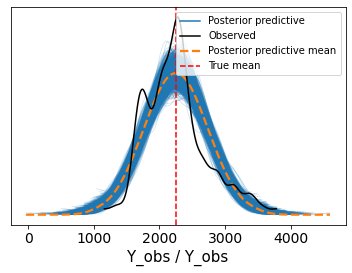

In [18]:
# draws *  #  chains = 2000
# plots simulated datasets against the observed data
fig, ax = plt.subplots()
az.plot_ppc(normal_trace, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

#### Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf6314b1d0>,
      dtype=object)

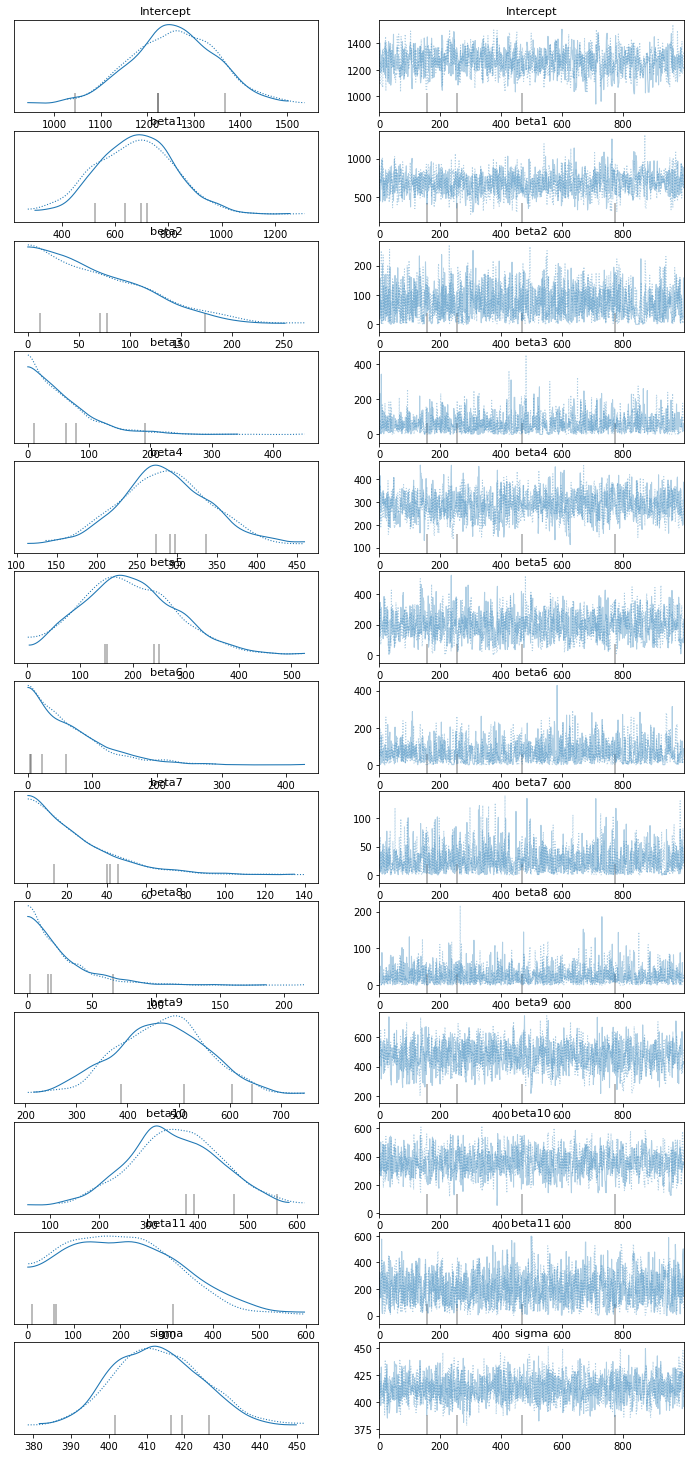

In [19]:
az.plot_trace(normal_trace)

#### Posterior Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf5876be90>,
      dtype=object)

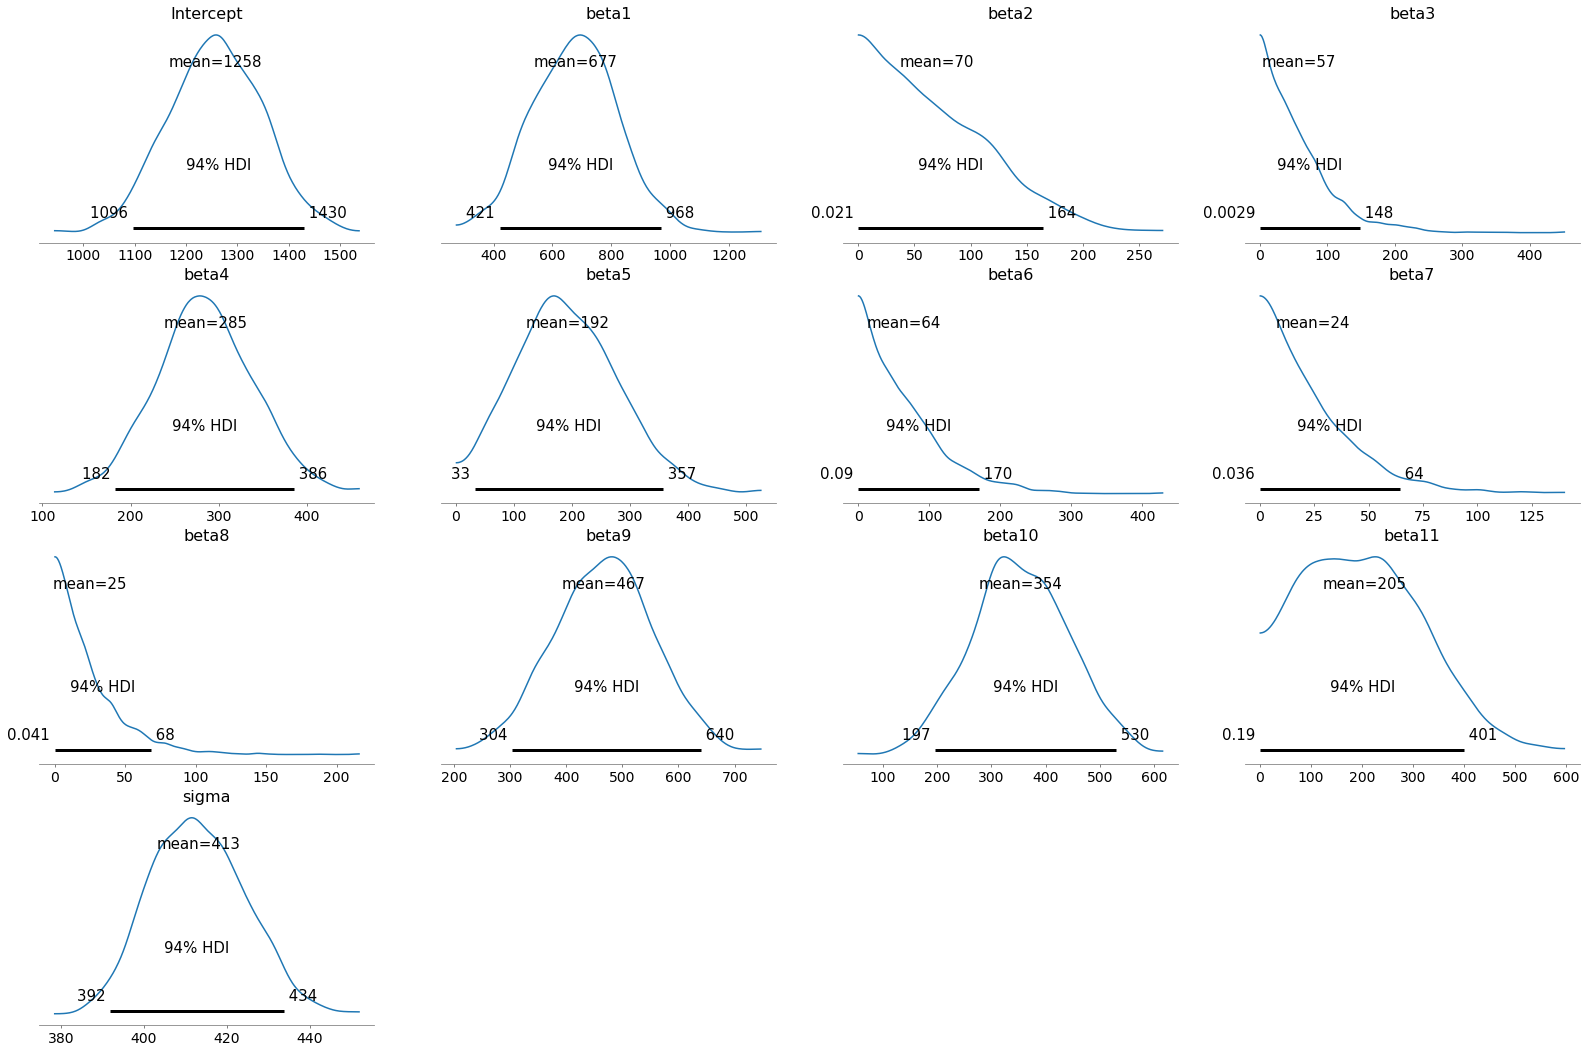

In [20]:
az.plot_posterior(normal_trace)

#### Forest Plot

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf581e82d0>,
      dtype=object)

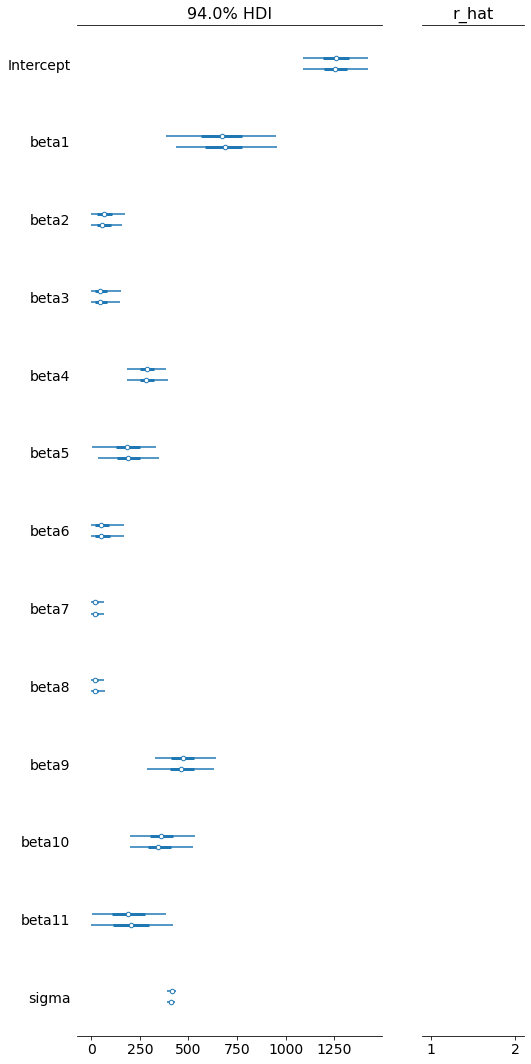

In [21]:
az.plot_forest(normal_trace, r_hat = True)

#### Summary Statistics

In [22]:
pm.summary(normal_trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1257.91000,90.28000,1096.08600,1430.25800,3.11900,2.20700,836.00000,783.00000,1.00000
beta1,677.21300,144.96500,421.09300,968.30000,4.72900,3.34500,933.00000,900.00000,1.01000
beta2,70.15500,52.07600,0.02100,163.90500,1.38900,0.98200,836.00000,541.00000,1.00000
beta3,56.94100,51.76600,0.00300,148.23500,1.35800,0.96000,868.00000,447.00000,1.00000
beta4,284.78900,54.92600,182.27800,385.67000,1.74300,1.23300,982.00000,1072.00000,1.00000
beta5,191.79900,88.32200,32.94100,356.61100,2.81400,1.99100,904.00000,800.00000,1.00000
beta6,64.46600,56.36100,0.09000,169.88000,1.75300,1.24000,680.00000,514.00000,1.00000
beta7,24.29100,21.94600,0.03600,64.16700,0.56700,0.40100,812.00000,913.00000,1.00000
beta8,24.81900,24.05900,0.04100,68.01000,0.60800,0.43000,937.00000,683.00000,1.00000
beta9,467.27500,90.15300,304.07300,639.57900,2.83500,2.00500,1014.00000,690.00000,1.00000


### Bayesian Evaluation Metrics and CV

#### BFMI

In [23]:
pm.bfmi(normal_trace)

array([0.96563508, 0.88302418])

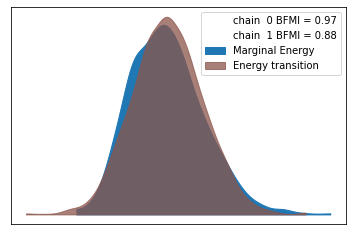

In [24]:
az.plot_energy(normal_trace)

#### WAIC/LOO/ELPD

In [25]:
pm.waic(normal_trace)

Computed from 2000 by 607 log-likelihood matrix

          Estimate       SE
elpd_waic -4522.24    19.72
p_waic        8.90        -

In [26]:
pm.loo(normal_trace, pointwise = True)

Computed from 2000 by 607 log-likelihood matrix

         Estimate       SE
elpd_loo -4522.24    19.72
p_loo        8.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      607  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Error Metrics

Obtain the average parameter estimates

In [27]:
var_dict = {}
for variable in model_trace.varnames:
  var_dict[variable] = model_trace[variable]
  
# Results into a dataframe
var_weights = pd.DataFrame(var_dict)
var_weights.drop(columns = ['Intercept_log__','beta1_log__','beta2_log__','beta3_log__','beta4_log__','beta5_log__','beta6_log__','sigma_log__', 'sigma'], inplace = True)
# Means for all the weights
var_means = var_weights.mean(axis=0)

In [28]:
var_means

beta7_log__    2.55023   
beta8_log__    2.66560   
beta9_log__    6.11770   
beta10_log__   5.81823   
beta11_log__   5.05941   
Intercept      1263.89679
beta1          673.21283 
beta2          70.58853  
beta3          56.61712  
beta4          280.95472 
beta5          194.34247 
beta6          64.26196  
beta7          22.18687  
beta8          25.19017  
beta9          463.64654 
beta10         349.83064 
beta11         206.37651 
dtype: float64

In [29]:
x['Intercept'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create predictions using the average parameter estimates

In [30]:
Y_pred = (var_means['Intercept']*x.Intercept) + (var_means['beta1'] *x['x2']) + (var_means['beta2'] *x['x16']) + (var_means['beta3'] *x['x17']) + (var_means['beta4'] *x['x26']) + (var_means['beta5'] *x['x27']) + (var_means['beta6'] *x['x32']) + (var_means['beta7'] *x['x34']) + (var_means['beta8'] *x['x35']) + (var_means['beta9'] *x['x38']) + (var_means['beta10'] *x['x39']) + (var_means['beta11'] *x['x45'])


In [31]:
residuals = Y_pred - y

#### MAE

In [32]:
mean_absolute_error(y,Y_pred)

319.3098296155568

#### MSE

In [33]:
mean_squared_error(y,Y_pred)

168353.60007440386

#### RMSE

In [34]:
rmse = np.sqrt(mean_squared_error(y,Y_pred))
rmse

410.3091518287203

#### R-Squared

In [35]:
az.r2_score(y, Y_pred)[0]

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py (511)

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 511:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.7/dist-packages/arviz/stats/stats_utils.py", line 512:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in data:


0.21620052326701075

### Calculate % Effect

In [36]:
print(round(100*(var_means['Intercept']*(x['Intercept']/Y_pred)).mean()))
print(round(100*(var_means['beta1']*(x['x2']/Y_pred)).mean()))
print(round(100*(var_means['beta2']*(x['x16']/Y_pred)).mean()))
print(round(100*(var_means['beta3']*(x['x17']/Y_pred)).mean()))
print(round(100*(var_means['beta4']*(x['x27']/Y_pred)).mean()))
print(round(100*(var_means['beta5']*(x['x27']/Y_pred)).mean()))
print(round(100*(var_means['beta6']*(x['x32']/Y_pred)).mean()))
print(round(100*(var_means['beta7']*(x['x34']/Y_pred)).mean()))
print(round(100*(var_means['beta8']*(x['x35']/Y_pred)).mean()))
print(round(100*(var_means['beta9']*(x['x38']/Y_pred)).mean()))
print(round(100*(var_means['beta10']*(x['x39']/Y_pred)).mean()))
print(round(100*(var_means['beta11']*(x['x45']/Y_pred)).mean()))


57
10
2
0
4
3
2
0
1
8
10
4


# Validate Linear Regression Model Assumptions

####1. Linearity

Visually inspect linearity between target variable and predictions

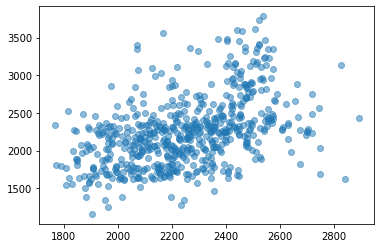

In [37]:
plt.plot(Y_pred,y,'o',alpha=0.5)
plt.show()

#### 2. Normality of Errors

Visually inspect the residuals to confirm normality

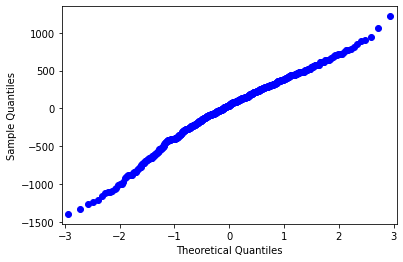

In [38]:
fig = sm.qqplot(residuals)

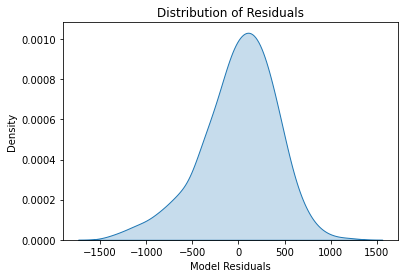

In [39]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

####3. Absence of Multicollinearity

Tested and checked during data processing stage

####4. Homoscedasticity


Visually inspect residuals to confirm constant variance

In [40]:
residuals.mean()

0.03648780716628209

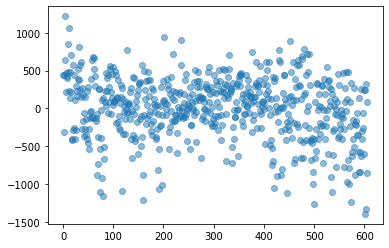

In [41]:
plt.plot(residuals,'o',alpha=0.5)
plt.show()

# Appendix

## Parameterization Help

Use the `fitter` package to auto-detect the probability distribution of your data

In [42]:
'''
sns.kdeplot(x[x.columns[3]], label = '', shade = True)
plt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');

f = Fitter(x[x.columns[2]],
           distributions= get_common_distributions())
f.fit()
f.summary()

f.get_best(method = 'aic')
f.fitted_param['uniform']
'''

"\nsns.kdeplot(x[x.columns[3]], label = '', shade = True)\nplt.xlabel(''); plt.ylabel('Density'); plt.title('Density Plot');\n\nf = Fitter(x[x.columns[2]],\n           distributions= get_common_distributions())\nf.fit()\nf.summary()\n\nf.get_best(method = 'aic')\nf.fitted_param['uniform']\n"